In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Data import

In [76]:
# Configuraciones para diferentes posiciones de las anclas (referencias):
# "pos": indica coordenadas cartesianas (m)
# "angulo": indica el ángulo del ancla respecto de la vertical (rad)

config_1 = {
"P1":{"pos": (56.69873, 75.0),"angulo": -1.0471975493043784},
"P2":{"pos": (94.770655, 109.771682),"angulo": -0.08726646965814552},
"P3":{"pos": (135.355339, 85.355339),"angulo": 0.7853981633974481}
}

config_2 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (34.467836, 95.886115),"angulo": -0.9599310909314129},
"P3":{"pos": (39.818498, 129.863551),"angulo": -0.6457718207490258}
}

config_3 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (40.548414, 103.530449),"angulo": -0.8377580360740813},
"P3":{"pos": (35.721239, 126.604444),"angulo": -0.6981317030426971}
}

config_4 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (43.332813, 106.469726),"angulo": -0.7871434894299918},
"P3":{"pos": (29.412843, 120.833984),"angulo": -0.7836528320585269}
}

# Posición esperada para el objetivo
p = (100, 50)


# 1. Matemathical Model

$$ A =
\begin{pmatrix}
\cos\theta_1 & -\sin\theta_1 \\
\cos\theta_2 & -\sin\theta_2 \\
\cos\theta_3 & -\sin\theta_3
\end{pmatrix}
\qquad
p =
\begin{pmatrix}
x \\
y
\end{pmatrix}
\qquad
b =
\begin{pmatrix}
x_1\cos\theta_1 - y_1\sin\theta_1 \\
x_2\cos\theta_2 - y_2\sin\theta_2 \\
x_3\cos\theta_3 - y_3\sin\theta_3
\end{pmatrix}
$$

Dado que el sistema es sobredeterminado, la solución estimada se obtiene mediante mínimos cuadrados:


$$ \hat p = (A^\top A)^{-1} A^\top b $$

En la práctica, las mediciones angulares están afectadas por ruido. Cada ángulo observado se modela como

$$
\theta_i^{\text{obs}} = \theta_i + \varepsilon_i
\qquad 
\varepsilon_i \sim \mathcal N(0,\sigma^2)
$$

de modo que las matrices $A$ y $b$ utilizadas en la estimación se construyen a partir de $\theta_i^{\text{obs}}$
y no de los valores verdaderos. La estabilidad del estimador de mínimos cuadrados depende críticamente del
número de condición de la matriz de diseño,


$$ \kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)} $$


In [ ]:
def estimate_p(angles, positions):
    A = np.column_stack([np.cos(angles), -np.sin(angles)])    # Design matrix
    b = np.sum(A * positions, axis = 1) # Solutions for linear system
    At = A.T
    x = np.linalg.inv(At @ A) @ At @ b  # Least Squares solution
    return  x, np.linalg.cond(A)

# 2. Simulation

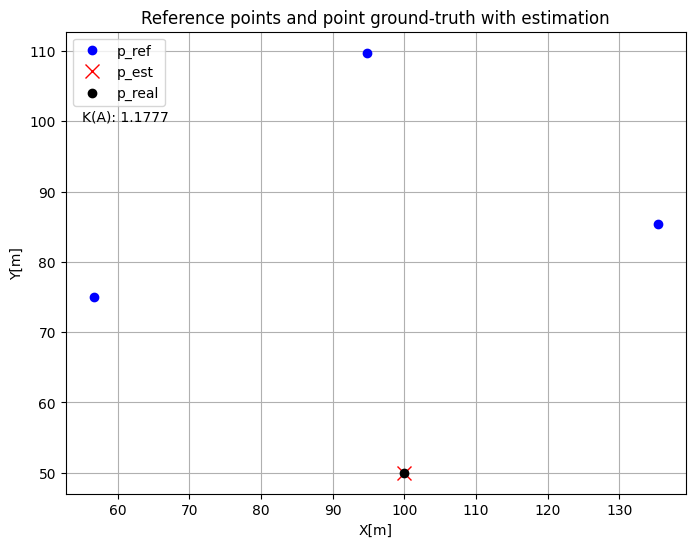

In [78]:
# Import config_1 and estimation the positionm of 'p'

theta_1 = np.array([config_1[p]['angulo'] for p in config_1.keys()])
pos_1 = np.array([config_1[p]['pos'] for p in config_1.keys()])

x, cond = estimate_p(theta_1, pos_1)

plt.figure(figsize=(8,6))
plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
plt.plot(x[0], x[1], 'x', markersize=10.0, color='red', label='p_est')
plt.plot(p[0], p[1], 'o', color='black', label='p_real')
plt.title('Reference points and point ground-truth with estimation')
plt.text(55, 100, f'K(A): {cond:.4f}')
plt.legend(loc='upper left')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.grid(True)
plt.show()

### Coordenadas ruidosas

$$
\tilde p_i = (x_i + \Delta x_i,\; y_i + \Delta y_i)
\qquad
\Delta x_i \sim \mathcal N(0,\sigma^2)
\qquad
\Delta y_i \sim \mathcal N(0,\sigma^2)
$$

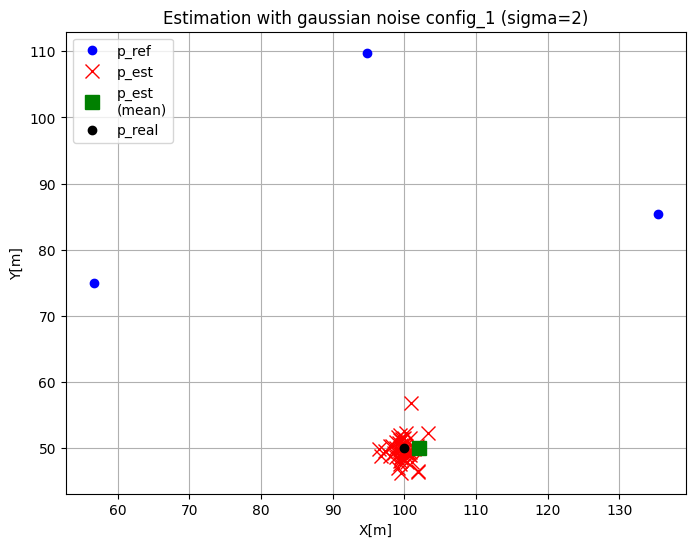

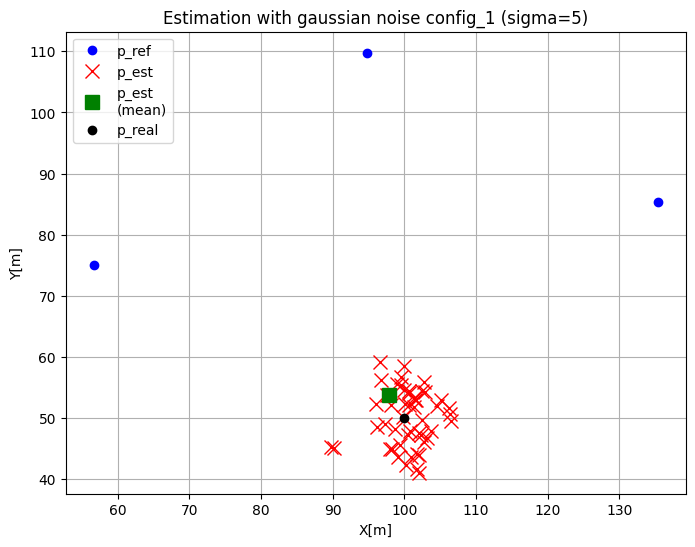

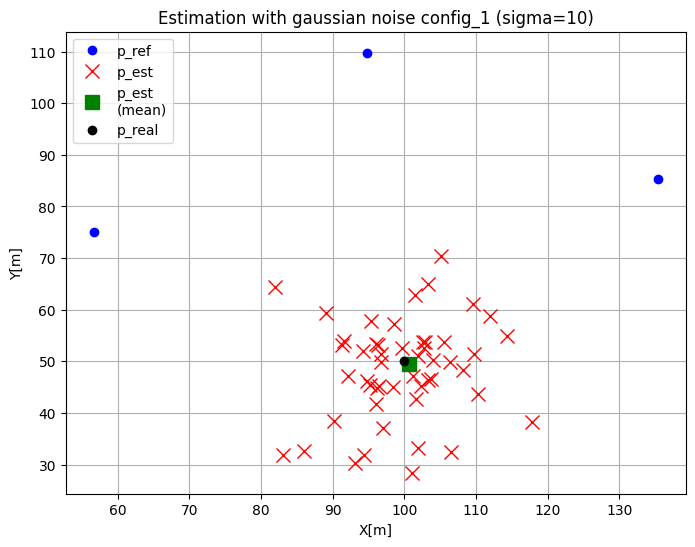

In [79]:
# Introducing gaussian noise to reference points's coordinates

rng = np.random.default_rng(42) # Random generator for reprodoctubility
sigmas = (2, 5, 10)
estimations = np.zeros((3, 50, 2))
for k in range(len(sigmas)):
    noisy_sampling = np.tile(pos_1, (50, 1, 1))
    noise = rng.normal(0, sigmas[k], size=(50, 3, 2))
    noisy_sampling += noise
    for i in range(noisy_sampling.shape[0]):
        x, cond = estimate_p(theta_1, noisy_sampling[i])
        estimations[k, i] = x

for i in range(estimations.shape[0]):
    plt.figure(figsize=(8,6))
    plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[i,:,0], estimations[i,:,1], 'x', markersize=10.0, color='red', label='p_est')
    plt.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
    plt.plot(p[0], p[1], 'o', color='black', label='p_real')
    plt.title(f'Estimation with gaussian noise config_1 (sigma={sigmas[i]})')
    plt.legend(loc='upper left')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()

###  Mediciones angulares afectadas por ruido

$$
\theta_i^{\text{obs}} = \theta_i + \varepsilon_i
\qquad 
\varepsilon_i \sim \mathcal N(0,\sigma^2)
$$


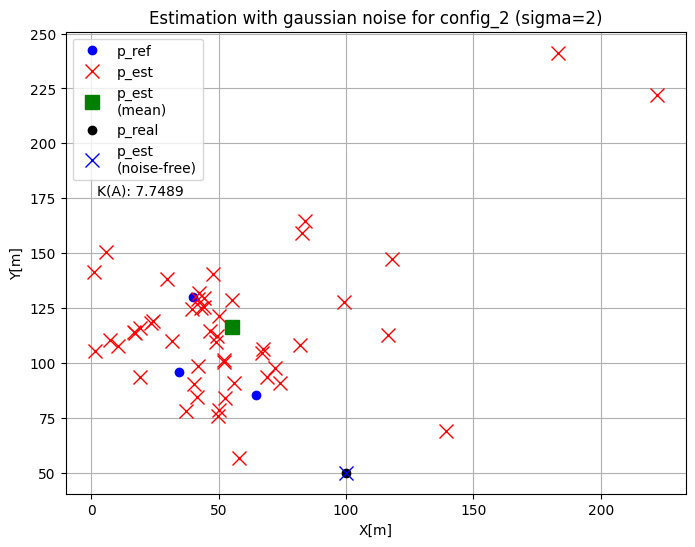

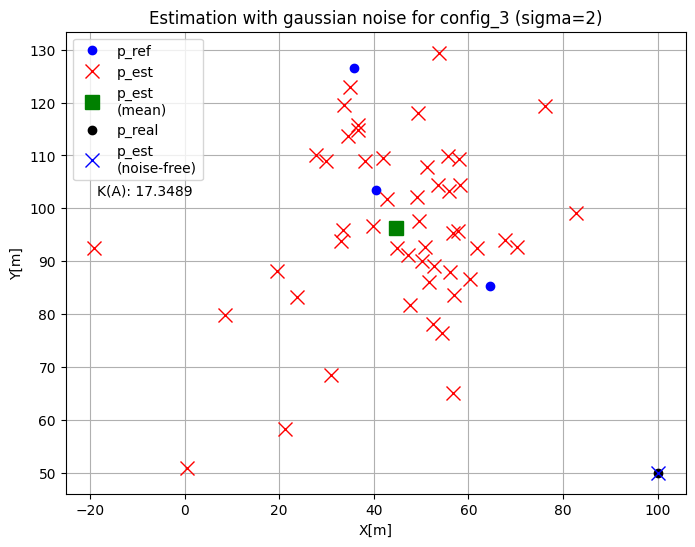

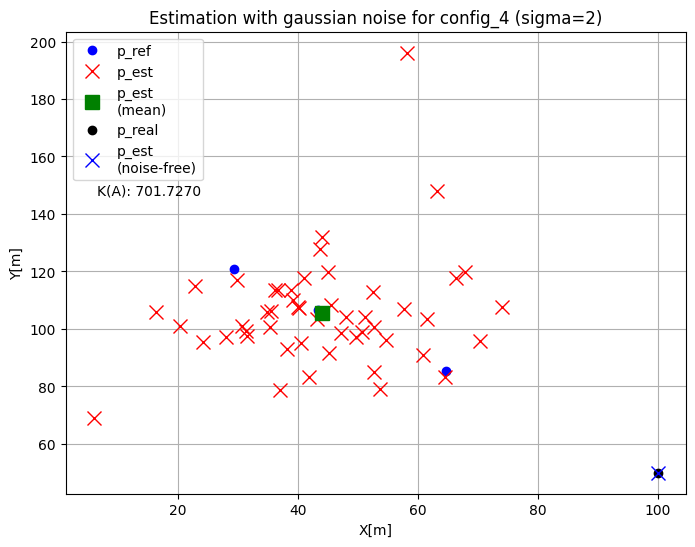

In [84]:
# Introducing gaussian noise into observed angles

thetas_234 = np.array([[config_2[p]['angulo'] for p in config_2.keys()],
                       [config_3[p]['angulo'] for p in config_3.keys()],
                       [config_4[p]['angulo'] for p in config_4.keys()]])
pos_234 = np.array([[config_2[p]['pos'] for p in config_2.keys()],
                    [config_3[p]['pos'] for p in config_3.keys()],
                    [config_4[p]['pos'] for p in config_4.keys()]
                   ])

# First we get the solution without noise and condition number of design matrix for a later comparison
conditions = np.zeros(3)
clean_solutions = np.zeros((3, 2))
for i in range(3):
    clean_solutions[i], conditions[i] = estimate_p(thetas_234[i], pos_234[i])

rng = np.random.default_rng(42) # Random generator for reprodoctubility
sigma = 2
estimations = np.zeros((50, 3, 2))
noise_angles = np.tile(thetas_234, (50, 1, 1))
noise = rng.normal(0, sigma, size=(50, 3, 3))
noise_angles += noise
for i in range(estimations.shape[0]):
    for j in range(estimations.shape[1]):
        x, cond = estimate_p(noise_angles[i,j,:], pos_234[j,:])
        estimations[i, j] = x

for i in range(estimations.shape[1]):
    plt.figure(figsize=(8,6))
    plt.plot(pos_234[i,:,0], pos_234[i,:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[:,i,0], estimations[:,i,1], 'x', markersize=10.0, color='red', label='p_est')
    plt.plot(np.mean(estimations[:,i,0]), np.mean(estimations[:,i,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
    plt.plot(p[0], p[1], 'o', color='black', label='p_real')
    plt.plot(clean_solutions[i][0], clean_solutions[i][1], 'x', markersize=10.0, color='blue', label='p_est\n(noise-free)')
    plt.title(f'Estimation with gaussian noise for config_{i+2} (sigma={sigma})')
    leg = plt.legend(loc='upper left')
    # For text alignment
    plt.gcf().canvas.draw()
    bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
    plt.text(0.05, 0.67, f'K(A): {conditions[i]:.4f}', transform=plt.gca().transAxes, ha='left', va='top')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()

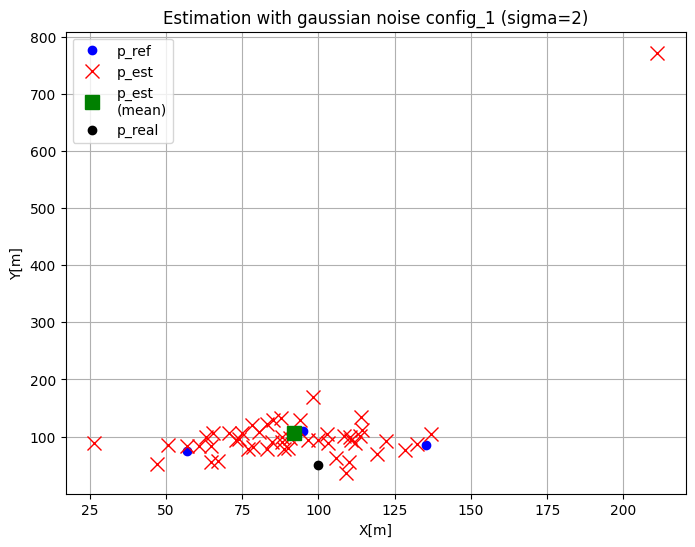

In [81]:
# EXTRA: Introducing gaussian noise to config_1 angles

rng = np.random.default_rng(42) # Random generator for reprodoctubility
sigma = 2
estimations = np.zeros((50, 2))
noisy_sampling = np.tile(theta_1, (50, 1))
noise = rng.normal(0, sigma, size=(50, 3))
noisy_sampling += noise
for i in range(noisy_sampling.shape[0]):
    x, cond = estimate_p(noisy_sampling[i], pos_1)
    #if x[1] > 500: continue 
    estimations[i] = x

plt.figure(figsize=(8,6))
plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
plt.plot(estimations[:,0], estimations[:,1], 'x', markersize=10.0, color='red', label='p_est')
plt.plot(np.mean(estimations[:,0]), np.mean(estimations[:,1]), 's', markersize=10.0, color='green', label='p_est\n(mean)')
plt.plot(p[0], p[1], 'o', color='black', label='p_real')
plt.title(f'Estimation with gaussian noise config_1 (sigma={sigma})')
plt.legend(loc='upper left')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.grid(True)
plt.show()

# 3. Experimento

In [ ]:
import utm

# Posición objetivo
p_latlon = (-34.446611, -58.529361)

# Referencias
ref1_latlon = (-34.446663, -58.529381)
ref2_latlon = (-34.446560, -58.529478)
ref3_latlon = (-34.446547, -58.529359)

: 

In [ ]:
# Conversión de coordenadas geográficas (lat, lon) a coordenadas cartesianas UTM (x, y)
# Esto permite trabajar en un sistema métrico plano compatible con el modelo lineal del TP.
p_utm = np.array(utm.from_latlon(*p_latlon)[:2])

# Posiciones UTM de las referencias
r1 = np.array(utm.from_latlon(*ref1_latlon)[:2])
r2 = np.array(utm.from_latlon(*ref2_latlon)[:2])
r3 = np.array(utm.from_latlon(*ref3_latlon)[:2])

In [ ]:
'''
Cálculo del ángulo de observación desde la posición real p hacia una referencia r.
Utilizamos arctan2(dx, dy) siguiendo el modelo del TP, donde:
   dx = x_r - x_p
   dy = y_r - y_p
La función arctan2 devuelve el ángulo en radianes respecto de la vertical, con signo 
según el sentido del giro.
'''
def angulo(p, r):
    dx = r[0] - p[0]
    dy = r[1] - p[1]
    theta = np.arctan2(dx, dy)
    return theta

# Ángulos hacia cada referencia (en radianes)
theta1 = angulo(p_utm, r1)
theta2 = angulo(p_utm, r2)
theta3 = angulo(p_utm, r3)

# Conversión a grados para análisis y verificación
theta1_deg = np.degrees(theta1)
theta2_deg = np.degrees(theta2)
theta3_deg = np.degrees(theta3)

In [ ]:
# Construcción del sistema lineal H p ≈ b según el modelo
# Apilamos las referencias en una matriz
refs = np.vstack([r1, r2, r3])

# Vector de angulos (theta_i)
thetas = np.array([theta1, theta2, theta3])
tans = np.tan(thetas)

# Matriz de diseño H
H = np.column_stack([tans, -np.ones_like(tans)])

# Vector independiente b
b = tans * refs[:,0] - refs[:,1]

In [ ]:
p_est = np.linalg.inv(H.T @ H) @ (H.T @ b)
print(f'La coordenada estimada es: {p_est}')

error = np.linalg.norm(p_est - p_utm)
print(f'El error de estimación es: {error}')

In [ ]:
#------ Plot de triangulación ------

plt.figure(figsize=(7,7))

# Referencias
plt.scatter(refs[:,0], refs[:,1], c="#1f77b4", s=90, label="Referencias")

for i, (x,y) in enumerate(refs):
    plt.text(x+0.25, y+0.25, f"Ref {i+1}", fontsize=10)

# Posición verdadera
plt.scatter(p_utm[0], p_utm[1], c="black", s=120, label="Posición verdadera")

# Estimada
plt.scatter(p_est[0], p_est[1], c="red", marker="x", s=150, label= "Estimada")

# Lineas desde la posición verdadera hacia cada referencia
for (x,y) in refs:
    plt.plot([p_utm[0], x], [p_utm[1], y], 
             linestyle="--", color="gray", linewidth=1)

plt.xlabel("x [m]", fontsize=12)
plt.ylabel("y [m]", fontsize=12)

plt.grid(color="lightgray", linestyle="--", linewidth=0.7)

plt.gca().set_aspect('equal', adjustable='box')

plt.ticklabel_format(useOffset=False)

plt.legend()
plt.show()